In [1]:
from bioformers.datasets.ArrowDataset import ArrowDataset
from bioformers.datasets import dataset_utils
from bioformers.utilize.Bert import BertSeqClassification
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import os
import numpy
import warnings 

from transformers import BertModel, BertTokenizer
import re

from datasets import load_dataset
from datasets import Dataset
from datasets import load_from_disk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["MKL_THREADING_LAYER"] = "GNU"
os.environ["TOKENIZERS_PARALLELISM"] = "true"
num_cpu = 16
max_length = 512
lr = '1.81e-5'

In [2]:
# load tokenizer and wandb logger

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
#model = BertModel.from_pretrained("Rostlab/prot_bert")

wandb_logger = WandbLogger(name=f"mel_lad-{lr}", project="hmm_reBERT")

In [3]:
# load csv to huggingface dataset AND pandas dataframe
dataset = load_dataset('csv', data_files="/mnt/storage/grid/home/eric/hmm2bert/data_prep/PuffinCaller_labelled_dataset_withFunctional.csv")
df = pd.read_csv("/mnt/storage/grid/home/eric/hmm2bert/data_prep/PuffinCaller_labelled_dataset_withFunctional.csv")
dataset1 = dataset['train']
print(dataset1.column_names)
print("")
print(df.head())
print(df.tail())

Using custom data configuration default-de9843ce42963bf9


Dataset csv downloaded and prepared to /home/eric/.cache/huggingface/datasets/csv/default-de9843ce42963bf9/0.0.0/2a88c45fed596f9421a2e7f74ab1a3cd012ef75210a5dc1950e8d60ca8d9c66c. Subsequent calls will reuse this data.
['sequence_ID', 'sequences', 'labels']

    sequence_ID                                          sequences  \
0  LasI-sample1  V T E L K L A G T Q K N F E F E F N K M A A F ...   
1  LasI-sample2  K M Q M V Q L G N E Y H L S R D I S Q I F N Q ...   
2  LasI-sample3  E I R I T I T A K L L D F R K I G A E A S R L ...   
3  LasI-sample4  H R A A A R P R L W S S E S Y D K E Q L H E L ...   
4  LasI-sample5  Q A M I I C G G R E H S F Q S S C E S I L S M ...   

                    labels  
0  acyl_homoserine_lactone  
1  acyl_homoserine_lactone  
2  acyl_homoserine_lactone  
3  acyl_homoserine_lactone  
4  acyl_homoserine_lactone  
       sequence_ID                                          sequences  \
197582  1206469164  A V V G M A A R Y A D A E D P R A L W D H L M ...   
1

In [4]:
# separate dataset into training and validation based on 'Labels' column in dataset

num_rows_list = list(range(len(dataset1)))
strat_train, strat_test = train_test_split(num_rows_list, stratify=dataset1['labels'], random_state=420)

print(len(strat_train))
print(len(strat_test))

148190
49397


In [43]:
#pass strat_train and strat_test into bioformers encoding function

strat_train_dataset = dataset_utils.encode_dataset(
    subset=Dataset.from_pandas(df.iloc[strat_train]),
    tokenizer=tokenizer,
    key="sequences",
    include_labels=True,
    padding="max_length",
    max_length=512,
    truncation=True
)

strat_train_dataset1 = strat_train_dataset.remove_columns(['sequence_ID', '__index_level_0__'])
#strat_train_dataset1.save_to_disk("/mnt/storage/grid/home/eric/hmm2bert/data_prep/test_train")
torch.save(strat_train_dataset1, "/mnt/storage/grid/home/eric/hmm2bert/data_prep/test_train.pt")

strat_test_dataset = dataset_utils.encode_dataset(
    subset=Dataset.from_pandas(df.iloc[strat_test]),
    tokenizer=tokenizer,
    key="sequences",
    include_labels=True,
    padding="max_length",
    max_length=512,
    truncation=True
)

strat_test_dataset1 = strat_test_dataset.remove_columns(['sequence_ID', '__index_level_0__'])
#strat_test_dataset1.save_to_disk("/mnt/storage/grid/home/eric/hmm2bert/data_prep/test_val")
torch.save(strat_test_dataset1, "/mnt/storage/grid/home/eric/hmm2bert/data_prep/test_val.pt")


In [3]:
#load train and test tensors and instantiate pytorch lightning wrapper for the huggingface model with the base pretrained protbert model

encoded_train = torch.load("/mnt/storage/grid/home/eric/hmm2bert/data_prep/test_train.pt")
encoded_test = torch.load("/mnt/storage/grid/home/eric/hmm2bert/data_prep/test_val.pt")

bsc = BertSeqClassification(pretrained_dir="Rostlab/prot_bert", use_adafactor=True, num_labels=2)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

In [4]:
# setup data collator, trainer, and dataloader for train and test dataset

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    max_epochs=9,
    gpus='0',
    auto_lr_find=False,
    logger=wandb_logger
)

warnings.filterwarnings("ignore")

train_dl = DataLoader(encoded_train, batch_size=4, num_workers=num_cpu, collate_fn=data_collator, shuffle=True)
eval_dl = DataLoader(encoded_test, batch_size=4, num_workers=num_cpu, collate_fn=data_collator, shuffle=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [5]:
lr_finder = trainer.tuner.lr_find(bsc, train_dataloader=train_dl, min_lr=float(1e-05), max_lr=float(0.0007), num_training=100, mode='exponential', early_stop_threshold=4)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name | Type                          | Params
-------------------------------------------------------
0 | bert | BertForSequenceClassification | 419 M 
-------------------------------------------------------
419 M     Trainable params
0         Non-trainable params
419 M     Total params
1,679.733 Total estimated model params size (MB)


Restored states from the checkpoint file at /mnt/storage/grid/home/eric/hmm2bert/lr_find_temp_model.ckpt


In [6]:
lr_finder.results

{'lr': [1e-05,
  1.0886843020781872e-05,
  1.1359335879307686e-05,
  1.1852335095914695e-05,
  1.23667306538358e-05,
  1.2903451161892693e-05,
  1.3463465530860151e-05,
  1.4047784722585121e-05,
  1.4657463575018212e-05,
  1.52936027064522e-05,
  1.5957350502405152e-05,
  1.664990518873499e-05,
  1.7372516994727962e-05,
  1.812649041006594e-05,
  1.8913186539746855e-05,
  1.9734025561209587e-05,
  2.0590489288098872e-05,
  2.1484123845298565e-05,
  2.2416542460062306e-05,
  2.3389428374280207e-05,
  2.4404537883138978e-05,
  2.546370350566099e-05,
  2.6568837292845836e-05,
  2.772193427938642e-05,
  2.8925076085190782e-05,
  3.018043467321118e-05,
  3.1490276270364385e-05,
  3.285696545862124e-05,
  3.428296944365095e-05,
  3.577086250872616e-05,
  3.732333066192895e-05,
  3.894317648504734e-05,
  4.063332419291553e-05,
  4.239682491233143e-05,
  4.423686219008095e-05,
  4.615675774001263e-05,
  4.8159977439537224e-05,
  5.0250137586377616e-05,
  5.243101142686382e-05,
  5.470653596755

# ==================LR FINDER=========================


0.012107442187570209


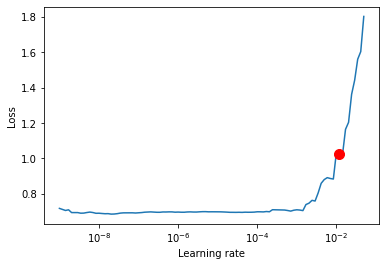

In [8]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.05 max, 1e-09 min, lowest 0.685303387716391


0.004711458863275393


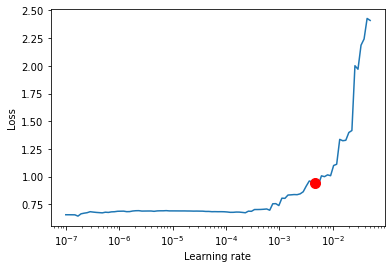

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.05 max, 1e-07 min, lowest 0.6423860596196121


0.00014070512065025699


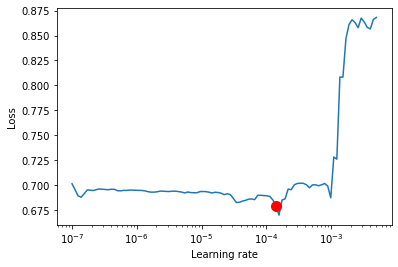

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.005 max, 1e-07 min, lowest 0.682493493312189


0.00010573712634405641


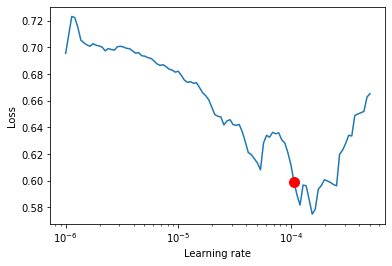

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.0005 max, 1e-06 min, lowest 0.5748709185996259


1.9810101489069607e-06


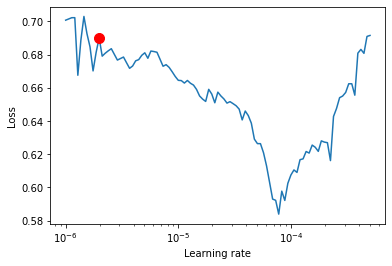

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.0001 max, 1e-06 min, lowest 0.5839379165659602


5.591737838964283e-05


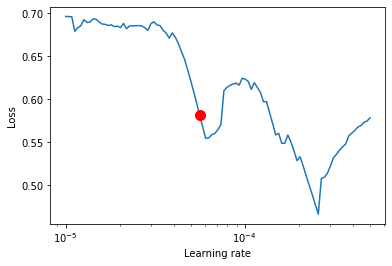

In [12]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.0005 max, 1e-05 min, lowest 0.4661554309066854


7.24213646665048e-05


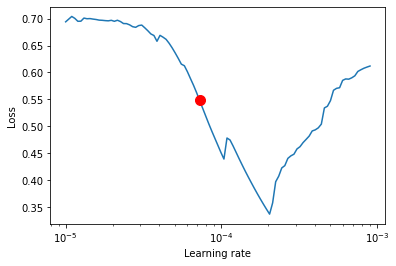

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.0009 max, 1e-05 min, lowest 0.3367288106823457


7.506221814863533e-05


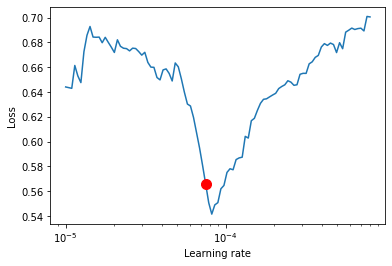

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.0008 max, 1e-05 min, lowest 0.5414100555126251


0.00012734053672728616


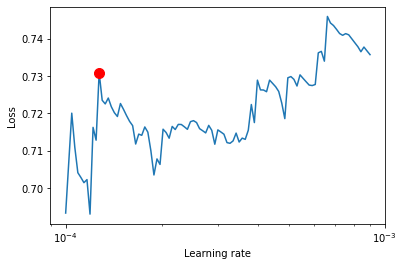

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.0009 max, 1e-04 min, lowest 0.6930772745100778


5.9558146928956545e-05


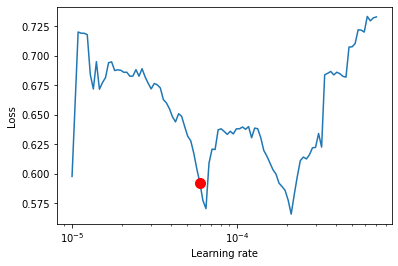

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.0007 max, 1e-05 min, lowest 0.5702901077431158